In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from keras.layers import LSTM
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers import Masking
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.layers import TimeDistributed

import keras
import matplotlib.pyplot as plt
import utm
from sklearn.model_selection import KFold
from sklearn.preprocessing import minmax_scale
from math import ceil
import math

def Dist_Error(pred,real):
    errors=np.abs(pred-real)
    result=[math.sqrt(math.pow(i[0],2)+math.pow(i[1],2))for i in errors]
    return np.array(result)


class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

# 读训练集
dataFrame=pd.read_csv('trainfix.csv')

maxleng=6

tra=dataFrame["TrajID"].unique()
dataset=[]
labelset=[]
for i in tra:
       x=dataFrame[dataFrame["TrajID"]==i]
       value=x[['RNCID_1', 'CellID_1', 'Dbm_1',
        'AsuLevel_1', 'SignalLevel_1', 'RNCID_2', 'CellID_2', 'Dbm_2',
        'AsuLevel_2', 'SignalLevel_2', 'RNCID_3', 'CellID_3', 'Dbm_3',
        'AsuLevel_3', 'SignalLevel_3', 'RNCID_4', 'CellID_4', 'Dbm_4',
        'AsuLevel_4', 'SignalLevel_4', 'RNCID_5', 'CellID_5', 'Dbm_5',
        'AsuLevel_5', 'SignalLevel_5', 'RNCID_6', 'CellID_6', 'Dbm_6',
        'AsuLevel_6', 'SignalLevel_6']].values
       dataset.append(value)
       labelset.append(x[['Latitude','Longitude']].values)
X=[]
y=[]
for i in range(len(dataset)):
       count=len(dataset[i])-maxleng+1
       for j in range(count):
              X.append(dataset[i][j:j+maxleng])
              y.append(labelset[i][j:j+maxleng])
X=np.array(X)
y_temp=np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_temp, test_size=0.2, random_state=33)

grid=pd.read_csv('grid1.csv')[['x','y']].values
y = []
for seq in y_temp:
    poses=[]
    for mr in seq:
        u1, u2, _, _ = utm.from_latlon(mr[0], mr[1])
        test = np.array([u1, u2])
        poses.append(np.argmin(np.sum(np.square(test - grid), axis=1)))
    y.append(poses)
y=to_categorical(np.array(y),891)

Y_train=[]
for seq in y_train:
    poses=[]
    for mr in seq:
        u1, u2, _, _ = utm.from_latlon(mr[0], mr[1])
        test = np.array([u1, u2])
        poses.append(np.argmin(np.sum(np.square(test - grid), axis=1)))
    Y_train.append(poses)

Y_train=to_categorical(np.array(Y_train),891)
Y_test=[]
y_test_utm=[]
for seq in y_test:
    poses=[]
    utms=[]
    for mr in seq:
        u1, u2, _, _ = utm.from_latlon(mr[0], mr[1])
        test = np.array([u1, u2])
        utms.append([u1, u2])
        poses.append(np.argmin(np.sum(np.square(test - grid), axis=1)))
    y_test_utm.append(utms)
    Y_test.append(poses)

Y_test=to_categorical(np.array(Y_test),891)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 32)             8064      
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 64)             24832     
_________________________________________________________________
dense_1 (Dense)              (None, 6, 1024)           66560     
_________________________________________________________________
dense_2 (Dense)              (None, 6, 512)            524800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 891)            457083    
_________________________________________________________________
activation_1 (Activation)    (None, 6, 891)            0         
Total params: 1,081,339
Trainable params: 1,081,339
Non-trainable params: 0
_________________________________________________________________


Epoch 71/600
9687/9687 [==============================] - 4s 451us/step - loss: 1.1468 - acc: 0.6373
Epoch 72/600
9687/9687 [==============================] - 4s 457us/step - loss: 1.1159 - acc: 0.6437
Epoch 73/600
9687/9687 [==============================] - 5s 491us/step - loss: 1.1002 - acc: 0.6535
Epoch 74/600
9687/9687 [==============================] - 5s 494us/step - loss: 1.0884 - acc: 0.6530
Epoch 75/600
9687/9687 [==============================] - 5s 494us/step - loss: 1.0663 - acc: 0.6621
Epoch 76/600
9687/9687 [==============================] - 5s 482us/step - loss: 1.1015 - acc: 0.6487
Epoch 77/600
9687/9687 [==============================] - 5s 496us/step - loss: 1.0510 - acc: 0.6644
Epoch 78/600
9687/9687 [==============================] - 5s 488us/step - loss: 1.0358 - acc: 0.6680
Epoch 79/600
9687/9687 [==============================] - 5s 496us/step - loss: 1.0364 - acc: 0.6700
Epoch 80/600
9687/9687 [==============================] - 5s 485us/step - loss: 0.9841 - ac

9687/9687 [==============================] - 4s 460us/step - loss: 0.6298 - acc: 0.7930
Epoch 152/600
9687/9687 [==============================] - 4s 443us/step - loss: 0.5713 - acc: 0.8110
Epoch 153/600
9687/9687 [==============================] - 5s 480us/step - loss: 0.5956 - acc: 0.8029
Epoch 154/600
9687/9687 [==============================] - 5s 490us/step - loss: 0.5506 - acc: 0.8175
Epoch 155/600
9687/9687 [==============================] - 5s 486us/step - loss: 0.5620 - acc: 0.8123
Epoch 156/600
9687/9687 [==============================] - 5s 490us/step - loss: 0.5671 - acc: 0.8128
Epoch 157/600
9687/9687 [==============================] - 5s 481us/step - loss: 0.5937 - acc: 0.8061
Epoch 158/600
9687/9687 [==============================] - 5s 490us/step - loss: 0.5742 - acc: 0.8126
Epoch 159/600
9687/9687 [==============================] - 5s 489us/step - loss: 0.5668 - acc: 0.8118
Epoch 160/600
9687/9687 [==============================] - 4s 462us/step - loss: 0.5921 - acc: 0

9687/9687 [==============================] - 5s 488us/step - loss: 0.4375 - acc: 0.8542
Epoch 232/600
9687/9687 [==============================] - 5s 484us/step - loss: 0.3959 - acc: 0.8678
Epoch 233/600
9687/9687 [==============================] - 5s 481us/step - loss: 0.4045 - acc: 0.8666
Epoch 234/600
9687/9687 [==============================] - 5s 492us/step - loss: 0.4258 - acc: 0.8595
Epoch 235/600
9687/9687 [==============================] - 5s 485us/step - loss: 0.4176 - acc: 0.8630
Epoch 236/600
9687/9687 [==============================] - 5s 484us/step - loss: 0.4277 - acc: 0.8589
Epoch 237/600
9687/9687 [==============================] - 5s 485us/step - loss: 0.3944 - acc: 0.8689
Epoch 238/600
9687/9687 [==============================] - 4s 459us/step - loss: 0.4099 - acc: 0.8644
Epoch 239/600
9687/9687 [==============================] - 5s 472us/step - loss: 0.4048 - acc: 0.8656
Epoch 240/600
9687/9687 [==============================] - 4s 460us/step - loss: 0.4284 - acc: 0

9687/9687 [==============================] - 5s 481us/step - loss: 0.3202 - acc: 0.8939
Epoch 312/600
9687/9687 [==============================] - 5s 491us/step - loss: 0.3314 - acc: 0.8884
Epoch 313/600
9687/9687 [==============================] - 5s 474us/step - loss: 0.3358 - acc: 0.8886
Epoch 314/600
9687/9687 [==============================] - 5s 487us/step - loss: 0.3535 - acc: 0.8817
Epoch 315/600
9687/9687 [==============================] - 5s 483us/step - loss: 0.3471 - acc: 0.8855
Epoch 316/600
9687/9687 [==============================] - 4s 463us/step - loss: 0.3042 - acc: 0.8993
Epoch 317/600
9687/9687 [==============================] - 5s 484us/step - loss: 0.3206 - acc: 0.8920
Epoch 318/600
9687/9687 [==============================] - 5s 472us/step - loss: 0.3187 - acc: 0.8943
Epoch 319/600
9687/9687 [==============================] - 4s 445us/step - loss: 0.3178 - acc: 0.8959
Epoch 320/600
9687/9687 [==============================] - 5s 470us/step - loss: 0.3452 - acc: 0

9687/9687 [==============================] - 5s 474us/step - loss: 0.2665 - acc: 0.9140
Epoch 392/600
9687/9687 [==============================] - 5s 489us/step - loss: 0.2737 - acc: 0.9095
Epoch 393/600
9687/9687 [==============================] - 5s 474us/step - loss: 0.2876 - acc: 0.9048
Epoch 394/600
9687/9687 [==============================] - 4s 462us/step - loss: 0.2608 - acc: 0.9126
Epoch 395/600
9687/9687 [==============================] - 5s 469us/step - loss: 0.2787 - acc: 0.9065
Epoch 396/600
9687/9687 [==============================] - 4s 455us/step - loss: 0.2760 - acc: 0.9071
Epoch 397/600
9687/9687 [==============================] - 5s 470us/step - loss: 0.2661 - acc: 0.9119
Epoch 398/600
9687/9687 [==============================] - 5s 484us/step - loss: 0.2645 - acc: 0.9116
Epoch 399/600
9687/9687 [==============================] - 5s 487us/step - loss: 0.2568 - acc: 0.9138
Epoch 400/600
9687/9687 [==============================] - 5s 491us/step - loss: 0.2662 - acc: 0

9687/9687 [==============================] - 5s 473us/step - loss: 0.2280 - acc: 0.9244
Epoch 472/600
9687/9687 [==============================] - 4s 461us/step - loss: 0.2405 - acc: 0.9203
Epoch 473/600
9687/9687 [==============================] - 5s 478us/step - loss: 0.2582 - acc: 0.9169
Epoch 474/600
9687/9687 [==============================] - 4s 449us/step - loss: 0.2373 - acc: 0.9211
Epoch 475/600
9687/9687 [==============================] - 4s 459us/step - loss: 0.2314 - acc: 0.9237
Epoch 476/600
9687/9687 [==============================] - 5s 486us/step - loss: 0.2343 - acc: 0.9235
Epoch 477/600
9687/9687 [==============================] - 5s 492us/step - loss: 0.2303 - acc: 0.9234
Epoch 478/600
9687/9687 [==============================] - 5s 478us/step - loss: 0.2501 - acc: 0.9178
Epoch 479/600
9687/9687 [==============================] - 5s 473us/step - loss: 0.2301 - acc: 0.9222
Epoch 480/600
9687/9687 [==============================] - 5s 490us/step - loss: 0.2340 - acc: 0

9687/9687 [==============================] - 5s 486us/step - loss: 0.2133 - acc: 0.9295
Epoch 552/600
9687/9687 [==============================] - 4s 459us/step - loss: 0.2058 - acc: 0.9311
Epoch 553/600
9687/9687 [==============================] - 4s 452us/step - loss: 0.2046 - acc: 0.9312
Epoch 554/600
9687/9687 [==============================] - 5s 487us/step - loss: 0.2187 - acc: 0.9268
Epoch 555/600
9687/9687 [==============================] - 5s 489us/step - loss: 0.1982 - acc: 0.9351
Epoch 556/600
9687/9687 [==============================] - 5s 483us/step - loss: 0.2254 - acc: 0.9253
Epoch 557/600
9687/9687 [==============================] - 5s 483us/step - loss: 0.2204 - acc: 0.9278
Epoch 558/600
9687/9687 [==============================] - 5s 490us/step - loss: 0.2010 - acc: 0.9343
Epoch 559/600
9687/9687 [==============================] - 5s 478us/step - loss: 0.1961 - acc: 0.9353
Epoch 560/600
9687/9687 [==============================] - 5s 482us/step - loss: 0.1957 - acc: 0

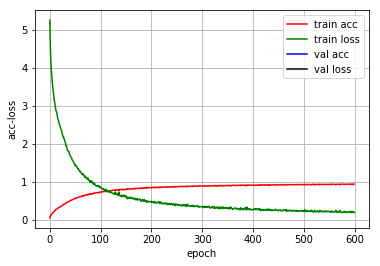

In [2]:
history = LossHistory()
def build_model():
    model=Sequential()
    model.add(LSTM(32,return_sequences=True,input_shape=(maxleng,30)))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dense(1024))
    model.add(Dense(512))
    model.add(TimeDistributed(Dense(891)))
    model.add(Activation('softmax'))
    r = Adam(lr=0.001)
    model.compile(optimizer=r,loss='categorical_crossentropy',metrics=['accuracy'])
    return model

model=build_model()
model.summary()
model.fit(X,y,epochs=600,batch_size=64, callbacks=[history])
# model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=600,batch_size=64, callbacks=[history])
history.loss_plot('epoch')

In [ ]:
testRe=model.predict_classes(X_test)
zone_number = 51
zone_letter = 'R'
testRe=testRe.reshape(-1)
y_test_utm=np.array(y_test_utm).reshape(-1,2)

testFi=[[grid[i][0], grid[i][1]] for i in testRe]
errors=Dist_Error(np.array(testFi),np.array(y_test_utm))
errors=np.array(errors)
print(np.median(errors))
print(np.mean(errors))
print(np.sort(errors)[int(len(errors)*0.9)])

In [ ]:
x = np.arange(0,np.max(errors))
error_y = [len(errors[errors < i])/len(errors) for i in x]
plt.plot(x, error_y)

In [3]:
def traj_merge(traj_id,trajs,code=0):
    maxleng=len(trajs[0])
    last=-1
    result=[]
    for i in range(len(traj_id)):
        if traj_id[i]!=last:
            result+=trajs[i]
            last=traj_id[i]
        else:
            result.append(trajs[i][maxleng-1])
    return result

In [4]:
dataTest=pd.read_csv('testfix.csv')

TrajID=dataTest["TrajID"].values
print(TrajID.shape)
traj=dataTest["TrajID"].unique()
dataT=[]
for i in range(len(traj)):
       x=dataTest[dataTest["TrajID"]==traj[i]]
       value=x[['RNCID_1', 'CellID_1', 'Dbm_1',
        'AsuLevel_1', 'SignalLevel_1', 'RNCID_2', 'CellID_2', 'Dbm_2',
        'AsuLevel_2', 'SignalLevel_2', 'RNCID_3', 'CellID_3', 'Dbm_3',
        'AsuLevel_3', 'SignalLevel_3', 'RNCID_4', 'CellID_4', 'Dbm_4',
        'AsuLevel_4', 'SignalLevel_4', 'RNCID_5', 'CellID_5', 'Dbm_5',
        'AsuLevel_5', 'SignalLevel_5', 'RNCID_6', 'CellID_6', 'Dbm_6',
        'AsuLevel_6', 'SignalLevel_6']].values
       dataT.append(value)

(2470,)


In [5]:
traj_id=[]
dataTfix=[]
for i in range(len(dataT)):
    count=len(dataT[i])-maxleng+1
    for j in range(count):
        dataTfix.append(dataT[i][j:j+maxleng])
        traj_id.append(i)
data_final=np.array(dataTfix)
y_pred = model.predict_classes(data_final)

In [6]:
y_p = traj_merge(traj_id,y_pred.tolist())
zone_number = 51
zone_letter = 'R'
y_final = [[utm.to_latlon(grid[i][0], grid[i][1], zone_letter=zone_letter, zone_number=zone_number)[1],
           utm.to_latlon(grid[i][0], grid[i][1], zone_letter=zone_letter, zone_number=zone_number)[0]] for i in y_p]
y_final = np.array(y_final)
df_pred = pd.DataFrame(data={'Longitude':y_final[:,0], 'Latitude':y_final[:,1]})
df_pred.to_csv('pred4.csv', index=False)
print('success')

success
